<a href="https://colab.research.google.com/github/JimKing100/DS-Unit-2-Kaggle-Challenge/blob/master/module2/DSPT2_Kaggle_Challenge_1_Module_2_Actual_Lesson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 2

### Objectives
- use scikit-learn for random forests
- understand how tree ensembles reduce overfitting compared to a single decision tree with unlimited depth
- do ordinal encoding with high-cardinality categoricals
- understand how categorical encodings affect trees differently compared to linear models

### Summary 

#### Try Tree Ensembles when you do machine learning with labeled, tabular data
- "Tree Ensembles" means Random Forest or Gradient Boosting models. 
- [Tree Ensembles often have the best predictive accuracy](https://arxiv.org/abs/1708.05070) with labeled, tabular data.
- Why? Because trees can fit non-linear, non-[monotonic](https://en.wikipedia.org/wiki/Monotonic_function) relationships, and [interactions](https://christophm.github.io/interpretable-ml-book/interaction.html) between features.
- A single decision tree, grown to unlimited depth, will [overfit](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/). We solve this problem by ensembling trees, with bagging (Random Forest) or boosting (Gradient Boosting).
- Random Forest's advantage: may be less sensitive to hyperparameters. Gradient Boosting's advantage: may get better predictive accuracy.

#### One-hot encoding isn’t the only way, and may not be the best way, of categorical encoding for tree ensembles.
- For example, tree ensembles can work with arbitrary "ordinal" encoding! (Randomly assigning an integer to each category.) Compared to one-hot encoding, the dimensionality will be lower, and the predictive accuracy may be just as good or even better.


### Setup

#### If you're using [Anaconda](https://www.anaconda.com/distribution/) locally

Install required Python package, if you haven't already:

- [category_encoders](http://contrib.scikit-learn.org/categorical-encoding/), version >= 2.0

```
conda install -c conda-forge category_encoders
```


In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module2')

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 133kB 9.1MB/s 
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
     |████████████████████████████████| 614kB 37.2MB/s 
     |████████████████████████████████| 225kB 42.6MB/s 
     |████████████████████████████████| 307kB 45.4MB/s 
     |████████████████████████████████| 51kB 20.0MB/s 
     |████████████████████████████████| 194kB 34.7MB/s 
     |████████████████████████████████| 727kB 32.5MB/s 
     |████████████████████████████████| 51kB 17.0MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=cc5b878d987c7e53817973726b4f2e9e60dcd8cf738cb43d6fc2158d3a924d03
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=f95fbcc6982039d170fab7979e1208d300711050e

## Solution example

> Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)


def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

## Use scikit-learn for random forests

[Scikit-Learn User Guide: Random Forests](https://scikit-learn.org/stable/modules/ensemble.html#random-forests) 

In [5]:
# TODO

%%time

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
   ce.OneHotEncoder(use_cat_names='True'),
   SimpleImputer(strategy='median'),
   RandomForestClassifier(n_estimators=5, random_state=42, n_jobs=-1) 
)

pipeline.fit(X_train, y_train)
print ('Validation Accuracy', pipeline.score(X_val, y_val))


Validation Accuracy 0.7846801346801346
CPU times: user 6.3 s, sys: 577 ms, total: 6.87 s
Wall time: 6.53 s


In [6]:
# TODO

import matplotlib.pyplot as plt
%matplotlib inline

rf = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded = encoder.transform(X_train)

importances = pd.Series(rf.feature_importances_, encoded.columns)
importances

amount_tsh                                     0.028667
gps_height                                     0.056315
longitude                                      0.113954
latitude                                       0.111183
num_private                                    0.001140
region_code                                    0.012918
district_code                                  0.018724
population                                     0.038908
construction_year                              0.037809
year_recorded                                  0.005087
month_recorded                                 0.018946
day_recorded                                   0.055827
years                                          0.034384
basin_Lake Nyasa                               0.003040
basin_Rufiji                                   0.002109
basin_Wami / Ruvu                              0.002705
basin_Lake Victoria                            0.002111
basin_Internal                                 0

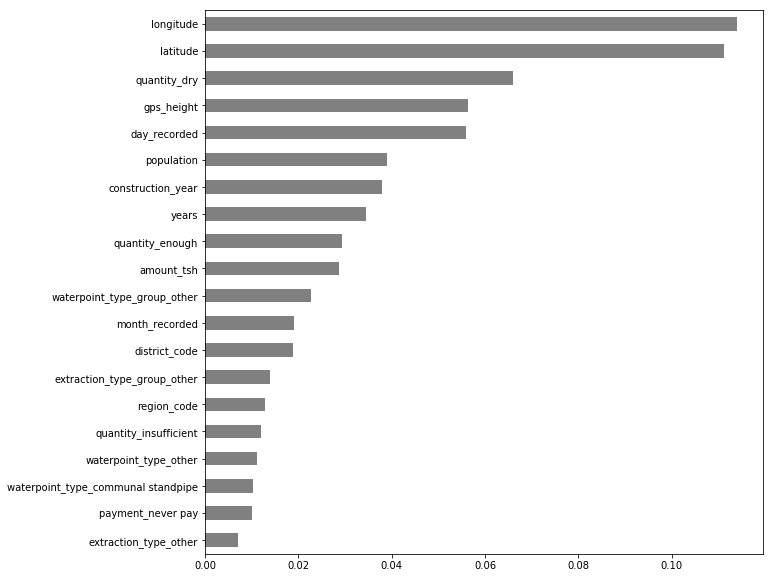

In [7]:
# TODO

n = 20
plt.figure(figsize=(10, 10))
importances.sort_values()[-n:].plot.barh(color='grey')

In [8]:
# TODO 

print ('X_train shape before encoding', X_train.shape)

encoder = pipeline.named_steps['onehotencoder']
encoded = encoder.transform(X_train)
print ('X_train shape after encoding', encoded.shape)


X_train shape before encoding (47520, 38)
X_train shape after encoding (47520, 182)


## Do ordinal encoding with high-cardinality categoricals

http://contrib.scikit-learn.org/categorical-encoding/ordinal.html

In [9]:
# TODO

%%time
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

pipeline = make_pipeline(
   ce.OrdinalEncoder(),
   SimpleImputer(strategy='median'),
   RandomForestClassifier(n_estimators=5, random_state=42, n_jobs=-1) 
)

pipeline.fit(X_train, y_train)
print ('Validation accuracy', pipeline.score(X_val, y_val))

Validation accuracy 0.7725589225589226
CPU times: user 2.28 s, sys: 66.2 ms, total: 2.34 s
Wall time: 1.9 s


In [10]:
print ('X_train shape before encoding', X_train.shape)

encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)

print ('X_train shape after encoding', encoded.shape)

X_train shape before encoding (47520, 45)
X_train shape after encoding (47520, 45)


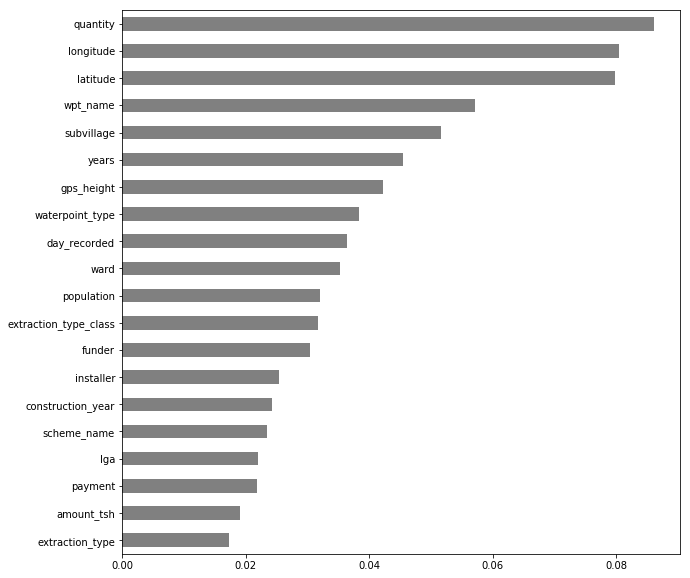

In [11]:

import matplotlib.pyplot as plt
%matplotlib inline

rf = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)

importances = pd.Series(rf.feature_importances_, encoded.columns)

n = 20
plt.figure(figsize=(10, 10))
importances.sort_values()[-n:].plot.barh(color='grey')

## Understand how tree ensembles reduce overfitting compared to a single decision tree with unlimited depth

In [0]:
# Explore the different features

feature = 'extraction_type_class'

In [13]:
X_train[feature].value_counts()

gravity         21448
handpump        13184
other            5193
submersible      4894
motorpump        2355
rope pump         353
wind-powered       93
Name: extraction_type_class, dtype: int64

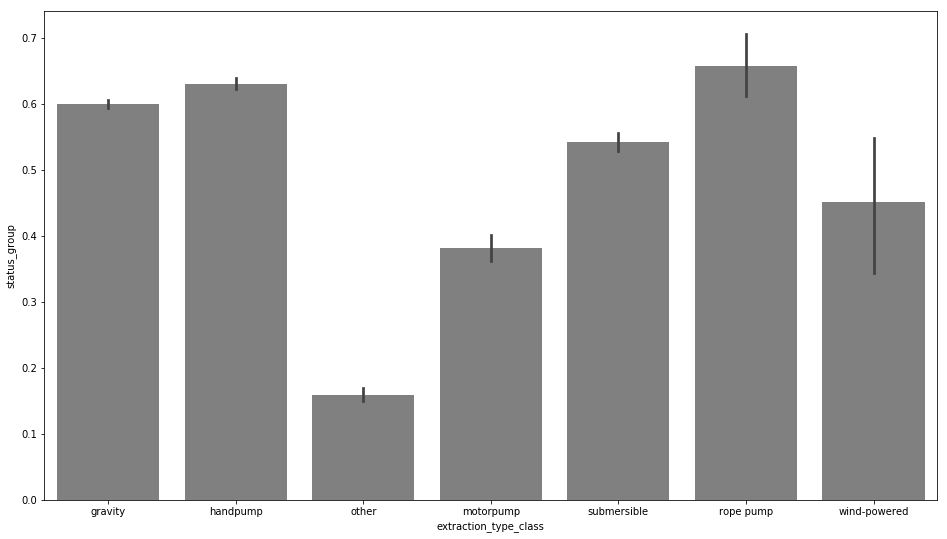

In [14]:
import seaborn as sns
plt.figure(figsize=(16,9))
sns.barplot(
    x=train[feature], 
    y=train['status_group']=='functional', 
    color='grey'
);

In [0]:
# What does this feature look like when we run it with one-hot encoding?

### [One Hot Encoding](http://contrib.scikit-learn.org/categorical-encoding/onehot.html)

> Onehot (or dummy) coding for categorical features, produces one feature per category, each binary.

Warning: May run slow, or run out of memory, with high cardinality categoricals!

In [16]:
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(X_train[[feature]])
print(f'{len(encoded.columns)} columns')
encoded.head(20)

7 columns


,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_other,extraction_type_class_motorpump,extraction_type_class_submersible,extraction_type_class_rope pump,extraction_type_class_wind-powered
43360,1,0,0,0,0,0,0
7263,1,0,0,0,0,0,0
2486,0,1,0,0,0,0,0
313,0,0,1,0,0,0,0
52726,0,0,0,1,0,0,0
8558,1,0,0,0,0,0,0
2559,1,0,0,0,0,0,0
54735,0,0,0,1,0,0,0
25763,0,1,0,0,0,0,0
44540,0,0,0,0,1,0,0


#### One-Hot Encoding, Logistic Regression, Validation Accuracy

In [17]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    StandardScaler(), 
    LogisticRegressionCV(multi_class='auto', solver='lbfgs', cv=5, n_jobs=-1)
)

lr.fit(X_train[[feature]], y_train)
score = lr.score(X_val[[feature]], y_val)
print('Logistic Regression, Validation Accuracy', score)

Logistic Regression, Validation Accuracy 0.6202861952861953


#### One-Hot Encoding, Decision Tree, Validation Accuracy

In [18]:
from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=42)
)

dt.fit(X_train[[feature]], y_train)
score = dt.score(X_val[[feature]], y_val)
print('Decision Tree, Validation Accuracy', score)

Decision Tree, Validation Accuracy 0.6202861952861953


#### One-Hot Encoding, Logistic Regression, Model Interpretation

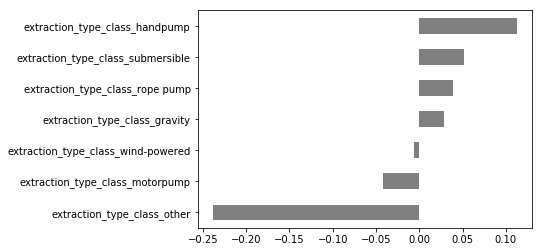

In [19]:
model = lr.named_steps['logisticregressioncv']
encoder = lr.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
coefficients.sort_values().plot.barh(color='grey');

#### One-Hot Encoding, Decision Tree, Model Interpretation

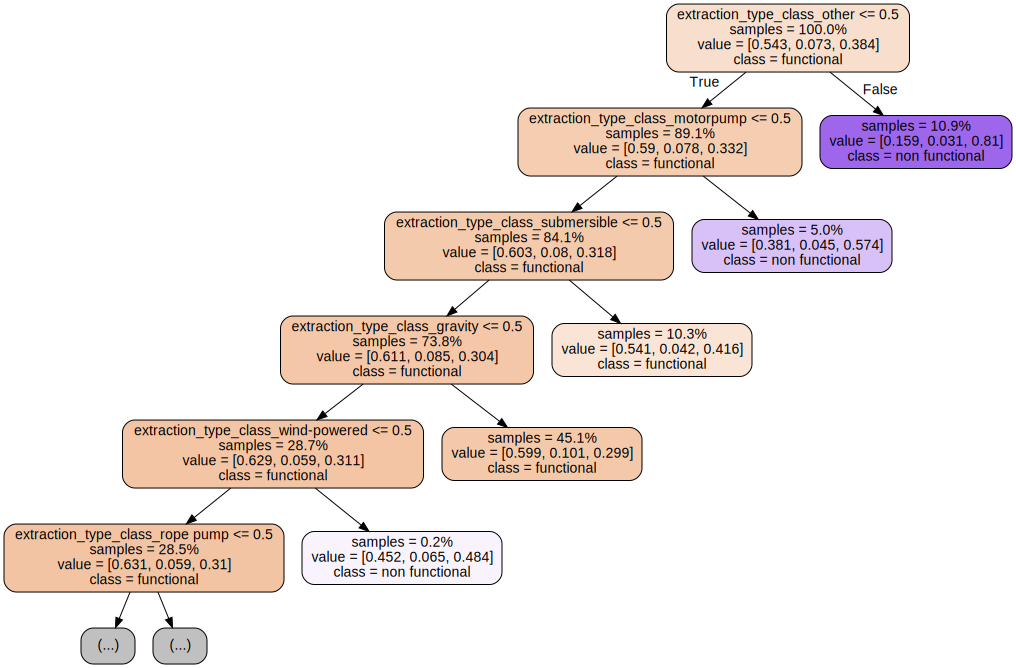

In [20]:
# Interpreting the features: each time, one-hot encoding only works with one class at a time.
# To interpret this breakdown, it becomes:  extraction_type_class < 0.5. This has to be zero or 1, Majority class is functional; 
#   -> the first branch- non-functional, which is 10.9% of the time. 

# Next branch: if the extraction_type_class is motorpump, then we're going to predict that it's non-functional.
# Next branch: submersible? predicts functional.

# Plot tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import graphviz
from sklearn.tree import export_graphviz

model = dt.named_steps['decisiontreeclassifier']
encoder = dt.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=5, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))



### [Ordinal Encoding](http://contrib.scikit-learn.org/categorical-encoding/ordinal.html)

> Ordinal encoding uses a single column of integers to represent the classes. An optional mapping dict can be passed in; in this case, we use the knowledge that there is some true order to the classes themselves. Otherwise, the classes are assumed to have no true order and integers are selected at random.

In [21]:
encoder = ce.OrdinalEncoder()
encoded = encoder.fit_transform(X_train[[feature]])
print(f'1 column, {encoded[feature].nunique()} unique values')
encoded.head(20)

1 column, 7 unique values


,extraction_type_class
43360,1
7263,1
2486,2
313,3
52726,4
8558,1
2559,1
54735,4
25763,2
44540,5


#### Ordinal Encoding, Logistic Regression, Validation Accuracy

In [23]:
# Accuracy is only slightly improved over the simple. 
# 
lr = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    StandardScaler(), 
    LogisticRegressionCV(multi_class='auto', solver='lbfgs', cv=5, n_jobs=-1)
)

lr.fit(X_train[[feature]], y_train)
score = lr.score(X_val[[feature]], y_val)
print('Logistic Regression, Validation Accuracy', score)

Logistic Regression, Validation Accuracy 0.5417508417508418


#### Ordinal Encoding, Decision Tree, Validation Accuracy

In [24]:
dt = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=42)
)

dt.fit(X_train[[feature]], y_train)
score = dt.score(X_val[[feature]], y_val)
print('Decision Tree, Validation Accuracy', score)

Decision Tree, Validation Accuracy 0.6202861952861953


#### Ordinal Encoding, Logistic Regression, Model Interpretation

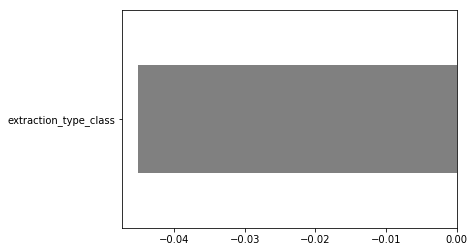

In [25]:
model = lr.named_steps['logisticregressioncv']
encoder = lr.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
coefficients.sort_values().plot.barh(color='grey');

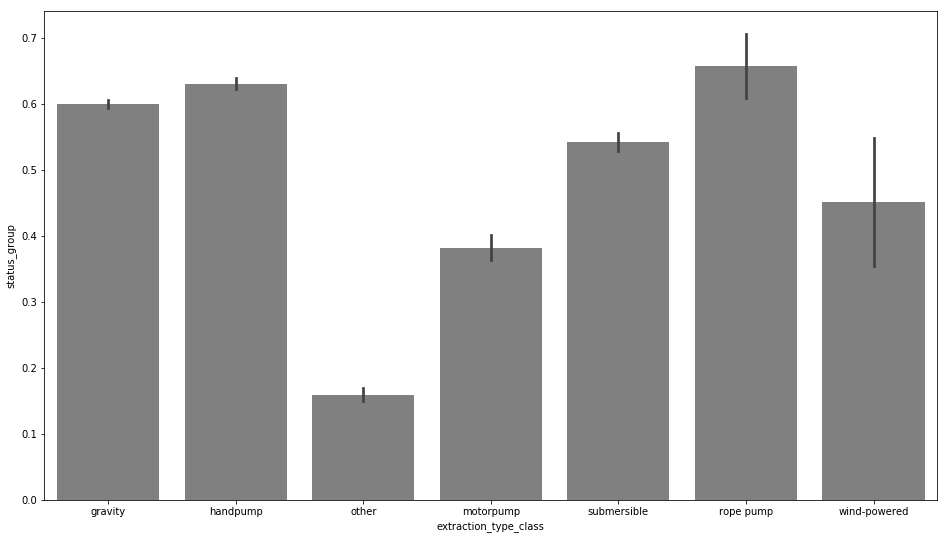

In [26]:
import seaborn as sns
plt.figure(figsize=(16,9))
sns.barplot(
    x=train[feature], 
    y=train['status_group']=='functional', 
    color='grey'
);

#### Ordinal Encoding, Decision Tree, Model Interpretation

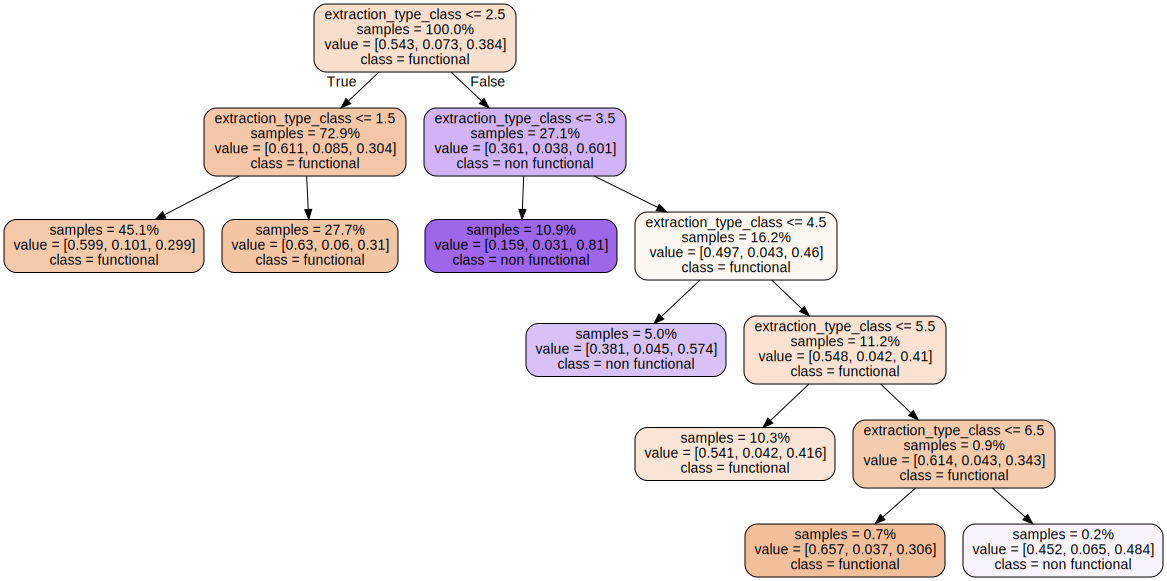

In [27]:
# We only need 5 levels instead of the seven from earlier. Data is partitioned more.
# 
model = dt.named_steps['decisiontreeclassifier']
encoder = dt.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=5, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

### Interlude: [predicting golf putts](https://statmodeling.stat.columbia.edu/2008/12/04/the_golf_puttin/)
(1 feature, non-linear, regression)

In [0]:
putts = pd.DataFrame(
    columns=['distance', 'tries', 'successes'], 
    data = [[2, 1443, 1346],
            [3, 694, 577],
            [4, 455, 337],
            [5, 353, 208],
            [6, 272, 149],
            [7, 256, 136],
            [8, 240, 111],
            [9, 217, 69],
            [10, 200, 67],
            [11, 237, 75],
            [12, 202, 52],
            [13, 192, 46],
            [14, 174, 54],
            [15, 167, 28],
            [16, 201, 27],
            [17, 195, 31],
            [18, 191, 33],
            [19, 147, 20],
            [20, 152, 24]]
)

putts['rate of success'] = putts['successes'] / putts['tries']
putts_X = putts[['distance']]
putts_y = putts['rate of success']

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

def putt_trees(max_depth=1, n_estimators=1):
    models = [DecisionTreeRegressor(max_depth=max_depth), 
              RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)]
    
    for model in models:
        name = model.__class__.__name__
        model.fit(putts_X, putts_y)
        ax = putts.plot('distance', 'rate of success', kind='scatter', title=name)
        ax.step(putts_X, model.predict(putts_X), where='mid')
        plt.show()
        
interact(putt_trees, max_depth=(1,6,1), n_estimators=(10,40,10));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=10, descripti…

### What's "random" about random forests?
1. Each tree trains on a random bootstrap sample of the data. (In scikit-learn, for `RandomForestRegressor` and `RandomForestClassifier`, the `bootstrap` parameter's default is `True`.) This type of ensembling is called Bagging. (Bootstrap AGGregatING.)
2. Each split considers a random subset of the features. (In scikit-learn, when the `max_features` parameter is not `None`.) 

For extra randomness, you can try ["extremely randomized trees"](https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees)!

>In extremely randomized trees (see [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) and [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html) classes), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias

### Bagging demo, with golf putts data
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

In [30]:
# Do-it-yourself Bagging Ensemble of Decision Trees (like a Random Forest)
def diy_bagging(max_depth=1, n_estimators=1):
    y_preds = []
    for i in range(n_estimators):
        title = f'Tree {i+1}'
        bootstrap_sample = putts.sample(n=len(putts), replace=True).sort_values(by='distance')
        bootstrap_X = bootstrap_sample[['distance']]
        bootstrap_y = bootstrap_sample['rate of success']
        tree = DecisionTreeRegressor(max_depth=max_depth)
        tree.fit(bootstrap_X, bootstrap_y)
        y_pred = tree.predict(bootstrap_X)
        y_preds.append(y_pred)
        ax = bootstrap_sample.plot('distance', 'rate of success', kind='scatter', title=title)
        ax.step(bootstrap_X, y_pred, where='mid')
        plt.show()
        
    ensembled = np.vstack(y_preds).mean(axis=0)
    title = f'Ensemble of {n_estimators} trees, with max_depth={max_depth}'
    ax = putts.plot('distance', 'rate of success', kind='scatter', title=title)
    ax.step(putts_X, ensembled, where='mid')
    plt.show()
    
interact(diy_bagging, max_depth=(1,6,1), n_estimators=(2,5,1));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=2, descriptio…

### Go back to Tanzania Waterpumps ...

#### Helper function to visualize predicted probabilities



In [0]:
import itertools
import seaborn as sns

def pred_heatmap(model, X, features, class_index=-1, title='', num=100):
    """
    Visualize predicted probabilities, for classifier fit on 2 numeric features
    
    Parameters
    ----------
    model : scikit-learn classifier, already fit
    X : pandas dataframe, which was used to fit model
    features : list of strings, column names of the 2 numeric features
    class_index : integer, index of class label
    title : string, title of plot
    num : int, number of grid points for each feature
    
    Returns
    -------
    y_pred_proba : numpy array, predicted probabilities for class_index
    """
    feature1, feature2 = features
    min1, max1 = X[feature1].min(), X[feature1].max()
    min2, max2 = X[feature2].min(), X[feature2].max()
    x1 = np.linspace(min1, max1, num)
    x2 = np.linspace(max2, min2, num)
    combos = list(itertools.product(x1, x2))
    y_pred_proba = model.predict_proba(combos)[:, class_index]
    pred_grid = y_pred_proba.reshape(num, num).T
    table = pd.DataFrame(pred_grid, columns=x1, index=x2)
    sns.heatmap(table)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(title)
    plt.show()
    return y_pred_proba


### Compare Decision Tree, Random Forest, Logistic Regression

In [32]:
# Instructions
# 1. Choose two features
# 2. Run this code cell
# 3. Interact with the widget sliders
feature1 = 'longitude'
feature2 = 'quantity'

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

def get_X_y(df, feature1, feature2, target):
    features = [feature1, feature2]
    X = df[features]
    y = df[target]
    X = X.fillna(X.median())
    X = ce.OrdinalEncoder().fit_transform(X)
    return X, y

def compare_models(max_depth=1, n_estimators=1):
    models = [DecisionTreeClassifier(max_depth=max_depth), 
              RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators), 
              LogisticRegression(solver='lbfgs', multi_class='auto')]
    
    for model in models:
        name = model.__class__.__name__
        model.fit(X, y)
        pred_heatmap(model, X, [feature1, feature2], class_index=0, title=name)

X, y = get_X_y(train, feature1, feature2, target='status_group')
interact(compare_models, max_depth=(1,6,1), n_estimators=(10,40,10));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=10, descripti…

### Bagging

In [33]:
# Do-it-yourself Bagging Ensemble of Decision Trees (like a Random Forest)

# Instructions
# 1. Choose two features
# 2. Run this code cell
# 3. Interact with the widget sliders

feature1 = 'longitude'
feature2 = 'latitude'

def waterpumps_bagging(max_depth=1, n_estimators=1):
    predicteds = []
    for i in range(n_estimators):
        title = f'Tree {i+1}'
        bootstrap_sample = train.sample(n=len(train), replace=True)
        X, y = get_X_y(bootstrap_sample, feature1, feature2, target='status_group')
        tree = DecisionTreeClassifier(max_depth=max_depth)
        tree.fit(X, y)
        predicted = pred_heatmap(tree, X, [feature1, feature2], class_index=0, title=title)
        predicteds.append(predicted)
    
    ensembled = np.vstack(predicteds).mean(axis=0)
    title = f'Ensemble of {n_estimators} trees, with max_depth={max_depth}'
    sns.heatmap(ensembled.reshape(100, 100).T)
    plt.title(title)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.xticks([])
    plt.yticks([])
    plt.show()
        
interact(waterpumps_bagging, max_depth=(1,6,1), n_estimators=(2,5,1));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=2, descriptio…